LOADING DATASET: WINE QUALITY

Dataset shape: (4898, 12)

First rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  qual

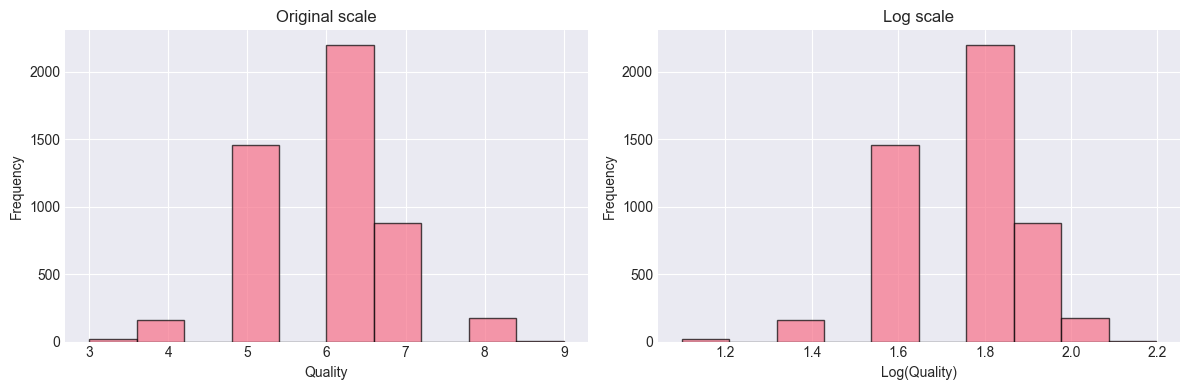


Missing values: 0


In [ ]:
# ----------------------------------------------------------------------------
# --- LOADING TOOLS AND DATA
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("LOADING DATASET: WINE QUALITY")
print("="*60)

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"

wine = pd.read_csv(DATA_DIR / "wineQuality/winequality-white.csv", sep=";")

print(f"\nDataset shape: {wine.shape}")
print(f"\nFirst rows:\n{wine.head()}")
print(f"\nSummary statistics:\n{wine.describe()}")

# Features e target
X = wine.drop('quality', axis=1)
y = wine['quality']

print(f"\nFeatures: {list(X.columns)}")
print(f"Target range: {y.min()} - {y.max()}")

# Visualise distribution target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y, bins=10, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Quality')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original scale')
axes[1].hist(np.log(y), bins=10, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Quality)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log scale')
plt.tight_layout()
plt.show()

# Check NA
na_count = wine.isnull().sum().sum()
print(f"\nMissing values: {na_count}")

# Check constant values
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"Constant columns: {constant_cols}")
    X = X.drop(columns=constant_cols)

In [ ]:
# ----------------------------------------------------------------------------
# --- K-FOLD CROSS-VALIDATION REGRESSION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION")
print("="*60)

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=1234)

# --- SUPPORT FUNCTIONS

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- DEFINE MODELS

models = {
    'lm': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'lasso': Lasso(alpha=0.01, max_iter=10000),
    'enet': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),
    'tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'rf': RandomForestRegressor(n_estimators=500, random_state=42, 
                                 max_features='sqrt', n_jobs=-1),
    'xgb': xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, 
                            max_depth=6, random_state=42, n_jobs=-1),
    'lgb': LGBMRegressor(n_estimators=300, learning_rate=0.1, 
                         num_leaves=31, random_state=42, n_jobs=-1, 
                         verbose=-1)
}

model_labels = {
    'lm': 'Linear Model',
    'ridge': 'Ridge',
    'lasso': 'Lasso',
    'enet': 'Elastic Net',
    'tree': 'Regression Tree',
    'rf': 'Random Forest',
    'xgb': 'XGBoost',
    'lgb': 'LightGBM'
}

# --- START LOOP FOR CV

predictions_all = {model_name: {'y_true': [], 'y_pred': []} 
                   for model_name in models.keys()}

fold_metrics = {model_name: [] for model_name in models.keys()}

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n--- FOLD {fold}/{K} ---")
    
    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Model by model
    for model_name, model in models.items():
        # Model Clone for this fold
        from sklearn.base import clone
        model_fold = clone(model)
        
        # Train
        model_fold.fit(X_train, y_train)
        
        # Predict
        y_pred = model_fold.predict(X_test)
        
        # Save predictions
        predictions_all[model_name]['y_true'].extend(y_test.values)
        predictions_all[model_name]['y_pred'].extend(y_pred)
        
        # Metrics per fold
        metrics = compute_metrics(y_test, y_pred)
        fold_metrics[model_name].append(metrics)

print("\n K-Fold CV completed!")


K-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---

--- FOLD 2/5 ---

--- FOLD 3/5 ---

--- FOLD 4/5 ---

--- FOLD 5/5 ---

 K-Fold CV completed!



PRESENTING THE RESULTS: MODELS COMPARISON

          Model  RMSE_mean  RMSE_sd  MAE_mean  R2_mean
  Random Forest   0.602959 0.028114  0.428498 0.534775
        XGBoost   0.627588 0.024546  0.446045 0.496069
       LightGBM   0.628178 0.021341  0.450718 0.495150
   Linear Model   0.755396 0.029838  0.586214 0.270323
          Ridge   0.757912 0.026276  0.588712 0.265579
    Elastic Net   0.765682 0.025850  0.599409 0.250558
          Lasso   0.766415 0.025554  0.600570 0.249134
Regression Tree   0.785480 0.026338  0.564750 0.211160

Best model: Random Forest
Mean RMSE: 0.6030 ± 0.0281
Mean R2: 0.5348


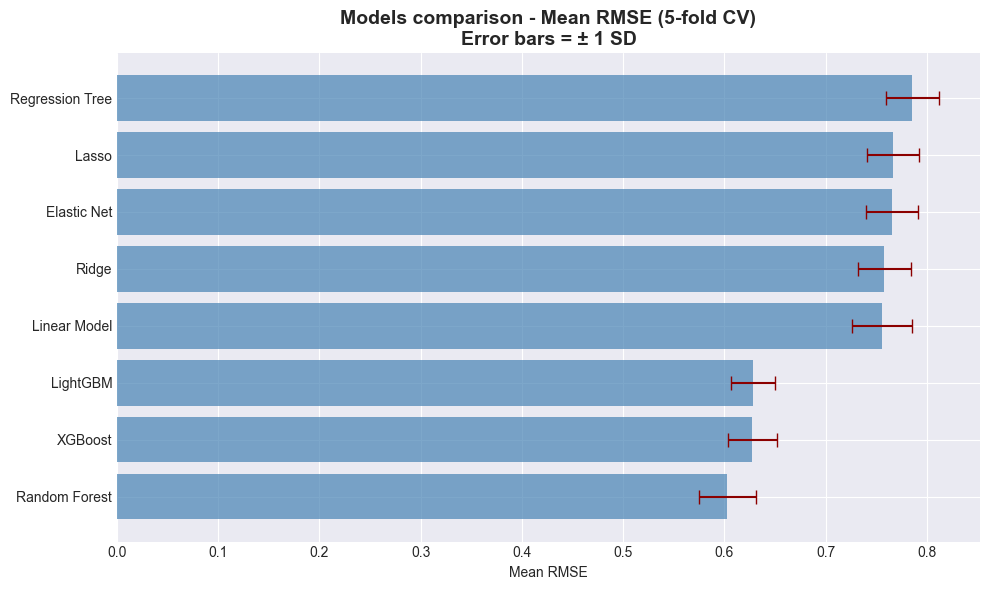

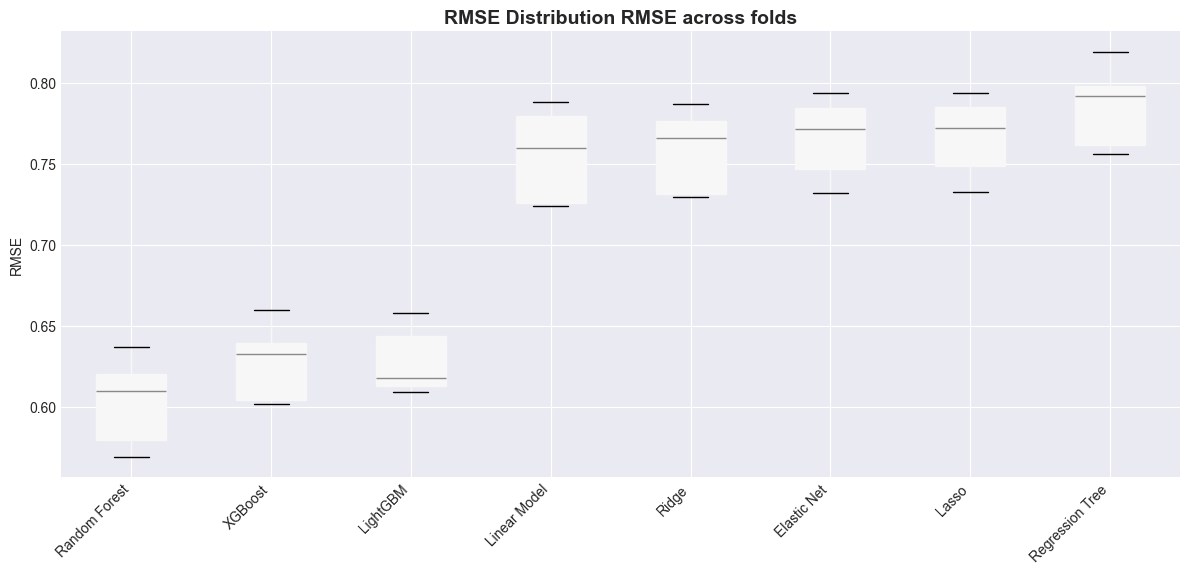

In [ ]:
# ----------------------------------------------------------------------------
# --- RESULTS AGGREGATION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("PRESENTING THE RESULTS: MODELS COMPARISON")
print("="*60)

cv_results = []

for model_name in models.keys():
    # Metrics per fold
    rmse_folds = [m['RMSE'] for m in fold_metrics[model_name]]
    mae_folds = [m['MAE'] for m in fold_metrics[model_name]]
    r2_folds = [m['R2'] for m in fold_metrics[model_name]]
    
    # Global metrics
    y_true_all = np.array(predictions_all[model_name]['y_true'])
    y_pred_all = np.array(predictions_all[model_name]['y_pred'])
    global_metrics = compute_metrics(y_true_all, y_pred_all)
    
    cv_results.append({
        'Model': model_labels[model_name],
        'Model_Code': model_name,
        'RMSE_mean': np.mean(rmse_folds),
        'RMSE_sd': np.std(rmse_folds, ddof=1),
        'MAE_mean': np.mean(mae_folds),
        'MAE_sd': np.std(mae_folds, ddof=1),
        'R2_mean': np.mean(r2_folds),
        'R2_sd': np.std(r2_folds, ddof=1),
        'RMSE_global': global_metrics['RMSE']
    })

cv_summary = pd.DataFrame(cv_results).sort_values('RMSE_mean')

print("\n" + cv_summary[['Model', 'RMSE_mean', 'RMSE_sd', 'MAE_mean', 'R2_mean']].to_string(index=False))

# Best model
best_model_row = cv_summary.iloc[0]
best_model_name = best_model_row['Model']
best_model_code = best_model_row['Model_Code']
best_rmse = best_model_row['RMSE_mean']
best_sd = best_model_row['RMSE_sd']

print(f"\nBest model: {best_model_name}")
print(f"Mean RMSE: {best_rmse:.4f} ± {best_sd:.4f}")
print(f"Mean R2: {best_model_row['R2_mean']:.4f}")

# --- VISUALS

# Plot 1: RMSE and error bars comparison
fig, ax = plt.subplots(figsize=(10, 6))
cv_summary_sorted = cv_summary.sort_values('RMSE_mean', ascending=False)
y_pos = np.arange(len(cv_summary_sorted))

ax.barh(y_pos, cv_summary_sorted['RMSE_mean'], alpha=0.7, color='steelblue')
ax.errorbar(cv_summary_sorted['RMSE_mean'], y_pos, 
            xerr=cv_summary_sorted['RMSE_sd'], 
            fmt='none', ecolor='darkred', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(cv_summary_sorted['Model'])
ax.set_xlabel('Mean RMSE')
ax.set_title('Models comparison - Mean RMSE (5-fold CV)\nError bars = ± 1 SD', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 2: Boxplot RMSE by fold
rmse_data = []
for model_name in models.keys():
    for fold_idx, metrics in enumerate(fold_metrics[model_name]):
        rmse_data.append({
            'Model': model_labels[model_name],
            'Fold': fold_idx + 1,
            'RMSE': metrics['RMSE']
        })

rmse_df = pd.DataFrame(rmse_data)
rmse_df['Model'] = pd.Categorical(
    rmse_df['Model'], 
    categories=cv_summary['Model'].values, 
    ordered=True
)

fig, ax = plt.subplots(figsize=(12, 6))
rmse_df.boxplot(column='RMSE', by='Model', ax=ax, patch_artist=True)
ax.set_xlabel('')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Distribution RMSE across folds', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove auto title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


RE-RUNNING THE BEST MODEL ON THE DATA
Final model: Random Forest
Adapted on 4898 observations

Variable Importance:
            Variable  Importance  Importance_Pct
             alcohol    0.164493       16.449350
             density    0.116802       11.680163
    volatile acidity    0.105483       10.548272
 free sulfur dioxide    0.105250       10.524990
total sulfur dioxide    0.082132        8.213171
           chlorides    0.081841        8.184064
      residual sugar    0.078129        7.812853
                  pH    0.070448        7.044771
         citric acid    0.069368        6.936804
       fixed acidity    0.064494        6.449381
           sulphates    0.061562        6.156181


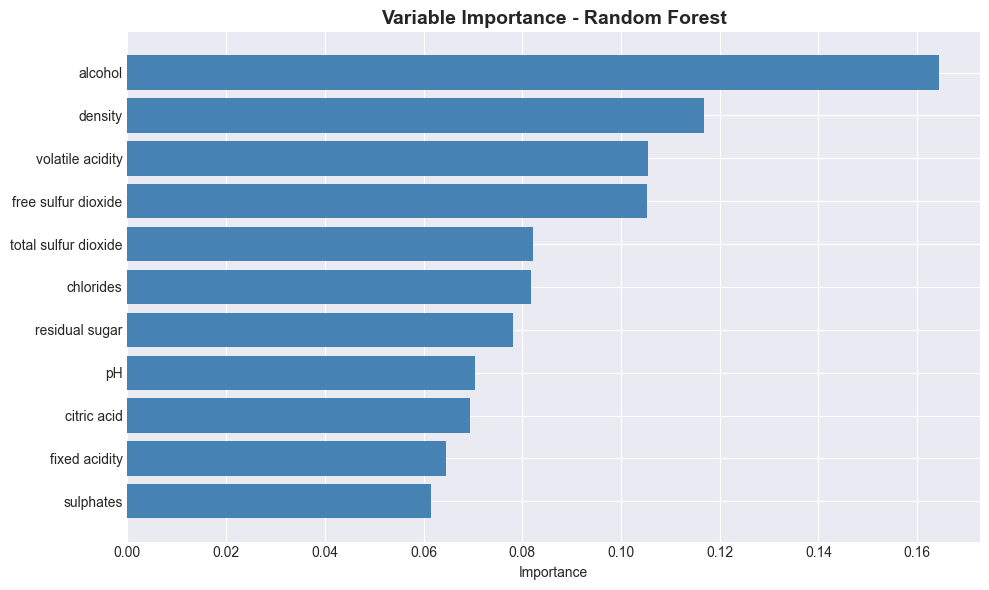


Training Performance:
RMSE: 0.2135
MAE: 0.1484
R²: 0.9419


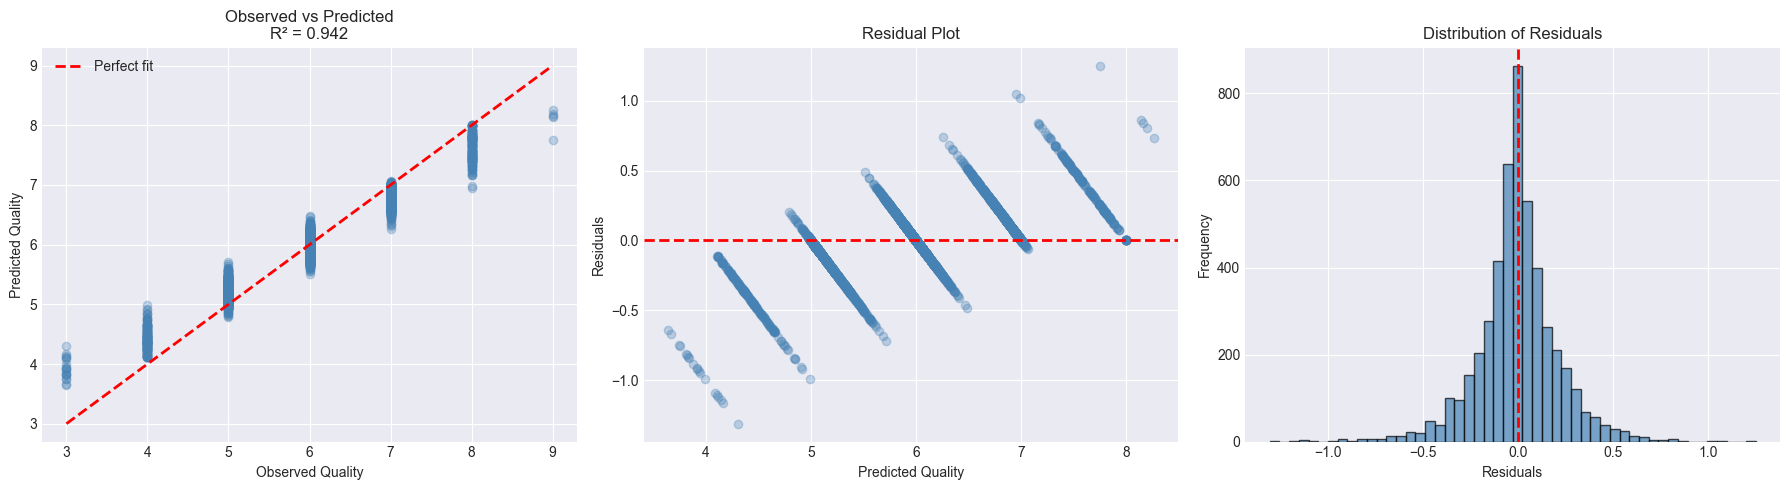


SUMMARY TABLE OF RESULTS

        Metric         Value
         Model Random Forest
n observations          4898
    n features            11
CV RMSE (mean)        0.6030
  CV RMSE (sd)        0.0281
 CV MAE (mean)        0.4285
  CV R² (mean)        0.5348
 Training RMSE        0.2135
   Training R2        0.9419

COMPLETED

Saved files:
- final_model_rf.pkl
- cv_results.csv
- summary_table.csv


In [ ]:
# ----------------------------------------------------------------------------
# --- RE-RUNNING OF BEST MODEL ON ENTIRE DATASET
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("RE-RUNNING THE BEST MODEL ON THE DATA")
print("="*60)

final_model = clone(models[best_model_code])
final_model.fit(X, y)

print(f"Final model: {best_model_name}")
print(f"Adapted on {len(y)} observations")

# save model
import pickle
with open(f'final_model_{best_model_code}.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# --- BEST MODEL ANALYSIS: RANDOM FOREST

# FEATURE IMPORTANCE ANALYSIS

if best_model_code in ['rf', 'xgb', 'lgb', 'tree']:
    
    # Variable importance
    if best_model_code == 'rf':
        importances = final_model.feature_importances_
    elif best_model_code == 'xgb':
        importances = final_model.feature_importances_
    elif best_model_code == 'lgb':
        importances = final_model.feature_importances_
    elif best_model_code == 'tree':
        importances = final_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Variable': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    importance_df['Importance_Pct'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
    
    print("\nVariable Importance:")
    print(importance_df.to_string(index=False))
    
    # Plot importance
    fig, ax = plt.subplots(figsize=(10, 6))
    importance_sorted = importance_df.sort_values('Importance', ascending=True)
    y_pos = np.arange(len(importance_sorted))
    ax.barh(y_pos, importance_sorted['Importance'], color='steelblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importance_sorted['Variable'])
    ax.set_xlabel('Importance')
    ax.set_title(f'Variable Importance - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Predictions
    y_pred_train = final_model.predict(X)
    train_metrics = compute_metrics(y, y_pred_train)
    
    print(f"\nTraining Performance:")
    print(f"RMSE: {train_metrics['RMSE']:.4f}")
    print(f"MAE: {train_metrics['MAE']:.4f}")
    print(f"R²: {train_metrics['R2']:.4f}")
    
    # Observed vs Predicted and Residuals
    residuals = y - y_pred_train
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Observed vs Predicted
    axes[0].scatter(y, y_pred_train, alpha=0.3, color='steelblue')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 
                 'r--', lw=2, label='Perfect fit')
    axes[0].set_xlabel('Observed Quality')
    axes[0].set_ylabel('Predicted Quality')
    axes[0].set_title(f'Observed vs Predicted\nR² = {train_metrics["R2"]:.3f}')
    axes[0].legend()
    
    # Residual plot
    axes[1].scatter(y_pred_train, residuals, alpha=0.3, color='steelblue')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Quality')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residual Plot')
    
    # Residuals histogram
    axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[2].set_xlabel('Residuals')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Distribution of Residuals')
    
    plt.tight_layout()
    plt.show()

elif best_model_code in ['ridge', 'lasso', 'enet', 'lm']:
    
    # Coefficients analysis
    if hasattr(final_model, 'coef_'):
        coefs = final_model.coef_
        intercept = final_model.intercept_
        
        coef_df = pd.DataFrame({
            'Variable': X.columns,
            'Coefficient': coefs
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print(f"\nIntercept: {intercept:.4f}\n")
        print("Coefficients:")
        print(coef_df.to_string(index=False))
        
        # Plot coefficients
        fig, ax = plt.subplots(figsize=(10, 6))
        coef_sorted = coef_df.sort_values('Coefficient', ascending=True)
        colors = ['darkred' if c < 0 else 'darkgreen' for c in coef_sorted['Coefficient']]
        y_pos = np.arange(len(coef_sorted))
        ax.barh(y_pos, coef_sorted['Coefficient'], color=colors, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(coef_sorted['Variable'])
        ax.axvline(x=0, color='black', linestyle='--', lw=1)
        ax.set_xlabel('Coefficient')
        ax.set_title(f'Coefficients - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# --- SUMMARY

print("\n" + "="*60)
print("SUMMARY TABLE OF RESULTS")
print("="*60)

summary_data = {
    'Metric': [
        'Model',
        'n observations',
        'n features',
        'CV RMSE (mean)',
        'CV RMSE (sd)',
        'CV MAE (mean)',
        'CV R² (mean)',
        'Training RMSE',
        'Training R2'
    ],
    'Value': [
        best_model_name,
        str(len(y)),
        str(X.shape[1]),
        f"{best_model_row['RMSE_mean']:.4f}",
        f"{best_model_row['RMSE_sd']:.4f}",
        f"{best_model_row['MAE_mean']:.4f}",
        f"{best_model_row['R2_mean']:.4f}",
        f"{train_metrics['RMSE']:.4f}" if 'train_metrics' in locals() else 'N/A',
        f"{train_metrics['R2']:.4f}" if 'train_metrics' in locals() else 'N/A'
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n" + summary_table.to_string(index=False))

# save results
cv_summary.to_csv('cv_results.csv', index=False)
summary_table.to_csv('summary_table.csv', index=False)

print("\n" + "="*60)
print("COMPLETED")
print("="*60)
print("\nSaved files:")
print(f"- final_model_{best_model_code}.pkl")
print("- cv_results.csv")
print("- summary_table.csv")